# Introduction

A group of investors would like to start a food business in Chicago, IL. The investors are agnostic to the location of the new business, but they have pre-selected 8 general locations. They would prefer for the business to be within a 0.5 mile radios of one of these locations:

1. Bucktown
2. Boystown
3. Roscoe Village
4. Logan Square
5. Wicker Park
6. Lincoln Park
7. Uptown
8. Near North Side

The goal of this report is to provide market research on all of the existing food businesses surrounding these 8 locations. The foursquare API will be used to collect information of all food businesses in the selected areas and present information regarding market saturation and popularity. 

Using this information, the investors will be able to make a more educated decision on which type of food business to start and in what location. 




# Data

All of the data used for this report will be sourced from the Foursquare API. The general business information that will be pulled from the API using the "Explore" endpoint, is the following:

1. Business Name
2. Business Food Category
3. Business Latitude
4. Business Longitude
5. Unique Business ID

In addition to the basic information provided by the "Explore" endpoint, using each businesses unique ID, the "Likes" endpoint will be utilized. This will provide a basic datapoint regrading the popularity or success of each business. 


# Methodology

Below is an explanation of the methodology used in this report. All of the code utilized in the analysis is accompanied by explantions and descriptions.


All required packages are imported and the 8 requested neighborhoods are loaded into the 'location_list' python list. 

Required login credientials for the Foursquare API are also saved.

In [1]:
from geopy.geocoders import Nominatim
import folium
import pandas as pd
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

CLIENT_ID = '4N2OKUVXD1N1RQYQJOCBRGF1GBGOML5KLC4WV1GNX0JH3U3S' 
CLIENT_SECRET = 'YZSH4L5VMESUMFUXNAP3AIZ10HZPZMKLV05QRGKA40I3JCVX' 
VERSION = '20180605'

location_list = [['Bucktown', 41.926897, -87.676661],
                 'Boystown, Chicago',
                 ['Roscoe Village', 41.943280, -87.679406],
                 'Logan Square, Chicago',
                 'Wicker Park, Chicago',
                 ['Lincoln Park', 41.925913, -87.648806],
                 'Uptown, Chicago',
                 'Near North Side, Chicago',]

Our location list is a combination of hard-coded coordinates and neighborhood names. If just a neighborhood name is identified, the latitude and longitude will be pulled using the following function:

In [2]:
for x, address in enumerate(location_list):
    if type(address) is not list:
        geolocator = Nominatim(user_agent="chi_explorer")
        location = geolocator.geocode(address)
        location_list[x] = [address.split(',')[0], location.latitude, location.longitude]
location_list

[['Bucktown', 41.926897, -87.676661],
 ['Boystown', 41.9438833, -87.6492669],
 ['Roscoe Village', 41.94328, -87.679406],
 ['Logan Square', 41.9285683, -87.7067931],
 ['Wicker Park', 41.9078018, -87.6781551],
 ['Lincoln Park', 41.925913, -87.648806],
 ['Uptown', 41.9666299, -87.6555458],
 ['Near North Side', 41.9000327, -87.6344975]]

The location list is now fully populated.

The following function will take our location list as an input. Using each location, the function will request all of the "food" related businesses from the Foursquare API in a 0.5 mile radius of each location. The function will request a maximum of 150 seperate businesses for each neighborhood. 

The results will be returned as a pandas dataframe object.

In [ ]:
def getFoodVenues(location_list, radius=805,limit=50):  
    food_list=[]
    for name, l1, l2 in location_list: 
        # create the API request URL
        for offset in [0,50,100]:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section=food&limit={}&offset={}'.format(
                CLIENT_ID,CLIENT_SECRET,VERSION, 
                l1,l2, 
                radius, 
                limit,offset)  
            # make the GET request
            results=requests.get(url)
            #print(results)
            results=results.json()["response"]['groups'][0]['items']
            #print(name, len(results))
            for item in results:
                food_list.append([name,l1,l2, 
                item['venue']['name'], 
                item['venue']['id'],
                item['venue']['location']['lat'], 
                item['venue']['location']['lng'],  
                item['venue']['categories'][0]['shortName']])
            if len(results) < 50:
                break

    venue_list=pd.DataFrame(food_list)
    venue_list.columns=['Location','Latitude','Longitude', 
                  'Business','id',
                  'Business Latitude','Business Longitude','Business Category']
    
    return venue_list

In [ ]:
df_food_bus = getFoodVenues(location_list)
df_food_bus

We now have a complete list of all the "food" related businesses in our selected neighborhooods. 

The Foursquare API returned a total of 686 business in the 8 different neighborhoods. Let's check to see if any of the businesses appear as a result for more than one neighborhood.

In [ ]:
len(df_food_bus.id.unique())

We also have 686 unique businesses. This means that we are not counting any specific business more than once and our neighborhoods have adequate seperation. 

Now we will request the "Like" data for each business from the Foursquare API. The following function requests the count of likes for each business in our list and returns the results as a pandas dataframe object.

In [ ]:
def pull_likes(ids):
    like_list = []
    for v_id in ids:
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
                v_id,CLIENT_ID,CLIENT_SECRET,VERSION,)
        results=requests.get(url).json()["response"]['likes']['count']
        like_list.append([v_id, results])
        
    df_list=pd.DataFrame(like_list)
    df_list.columns=['id','Likes']
    return df_list


We have succesffully requested all of the "Like" data for each business. Now we will merge the like data with our other business data using the Foursquare unique id. 

In [ ]:
df_likes = pull_likes(df_food_bus.id.unique())
df_food_bus = pd.merge(df_food_bus, df_likes, on="id")
df_food_bus

All of the data has now been combined into a single dataframe object. Requesting the "Like" data is very time consuming using the Foursquare API. For this reason we will save our combined dataframe object as a CSV file. Now, anyone else trying to confirm the data, can simply import the csv data without having to make time consuming calls to the Foursquare API.

In [ ]:
df_food_bus.to_csv('food_list.csv', index=False)

In [3]:
df_food_bus = pd.read_csv('food_list.csv')
df_food_bus.head()

,Location,Latitude,Longitude,Business,id,Business Latitude,Business Longitude,Business Category,Likes
0,Bucktown,41.926897,-87.676661,Vienna Beef Factory Store & Cafe,4b2fc693f964a520b0ef24e3,41.926136,-87.677651,Hot Dogs,89
1,Bucktown,41.926897,-87.676661,CRĪO,5355d7bb498eeed72bc2a0b7,41.927030,-87.672064,Latin American,34
2,Bucktown,41.926897,-87.676661,Taco Bell,4a7bbb8ff964a520b7eb1fe3,41.928577,-87.673296,Fast Food,111
3,Bucktown,41.926897,-87.676661,The Bristol,49ebe3cbf964a5203f671fe3,41.921223,-87.677758,New American,229
4,Bucktown,41.926897,-87.676661,Asian Cajun,56b2b238498ec9031ecf5c13,41.926061,-87.668434,Seafood,17


# Results

All of the required data has been extracted from the Foursquare API. We can now begin reviewing the results of the data to extract actionable market insights. 

Let's begin by mapping all of the individual businesses. We will map each location with a different color indicating it's neighborhood.

* Red - Near North Side
* Gold - Lincoln Park
* Blue - Boystown
* Orange - Uptown
* Pale Blue - Roscoe Village
* Purple - Bucktown
* Green - Wicker Park
* Aqua - Logan Square



In [4]:
colors_array = cm.rainbow(np.linspace(0, 1, len(location_list)))
rainbow = {}
for x, each in enumerate(location_list):
    rainbow[each[0]] = colors.rgb2hex(colors_array[x])

In [5]:
map_t = folium.Map(location=[location_list[0][1], location_list[0][2]], zoom_start=12)

# add markers to map
for lat, lng, location in zip(df_food_bus['Business Latitude'], df_food_bus['Business Longitude'], df_food_bus['Location']):
    folium.CircleMarker([lat, lng],radius=5,color=rainbow[location],fill=True,fill_color=rainbow[location],fill_opacity=0.7,parse_html=False).add_to(map_t)  
    
map_t

A screenshot is provided if mapping libraries are not available on your system.
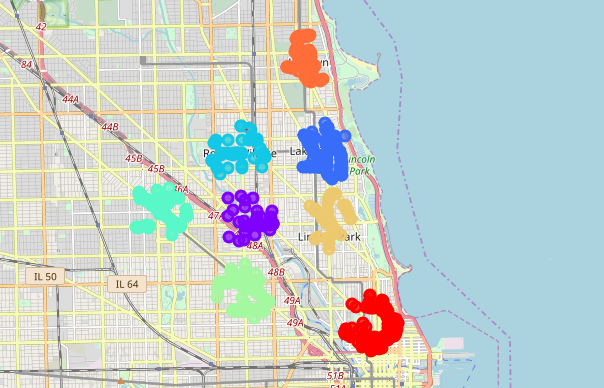

Now let's explore the general trends of all the data we have captured.

Below is the number of businesses we have identified in each location:

In [6]:
location_count = pd.Series(df_food_bus.groupby('Location').id.count())
location_count

Location
Boystown           114
Bucktown            35
Lincoln Park        45
Logan Square        84
Near North Side    141
Roscoe Village      55
Uptown              78
Wicker Park        134
Name: id, dtype: int64

The 10 most popular food business catagories are listed below:

In [7]:
ten_most_common = pd.Series(df_food_bus.groupby('Business Category').id.count()).nlargest(10)
ten_most_common


Business Category
Pizza         52
Mexican       41
Sandwiches    35
Bakery        28
Italian       28
American      27
Sushi         27
Café          25
Breakfast     23
Restaurant    23
Name: id, dtype: int64

Using the ten most popular business categories, we will graph the distribution of likes. A box plot graph has been chosen to represnt the distribution of likes for each category.

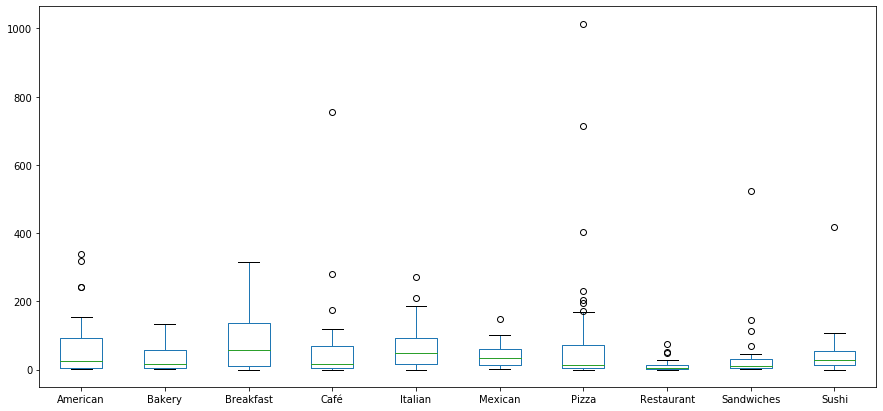

In [8]:
ten_mc_df = df_food_bus[df_food_bus['Business Category'].isin(ten_most_common.index)].loc[:,['Business Category','Likes']]
df2 = ten_mc_df.pivot(columns=ten_mc_df.columns[0], index=ten_mc_df.index)
df2.columns = df2.columns.droplevel()
df2.boxplot(figsize=(15,7), grid=False)


As you can see, Breakfast and Italian restaurants have the highest mean like count. (Represented by the green line in each box).

______________

Now we will sum the total amount of likes for each restaurant category.

In [9]:
ten_most_liked = pd.Series(df_food_bus.groupby('Business Category').Likes.sum()).nlargest(10)
ten_most_liked

Business Category
Pizza           4314
Tacos           2928
Hot Dogs        2833
New American    2262
Breakfast       2006
American        1963
Italian         1903
Café            1828
Steakhouse      1817
Mexican         1680
Name: Likes, dtype: int64

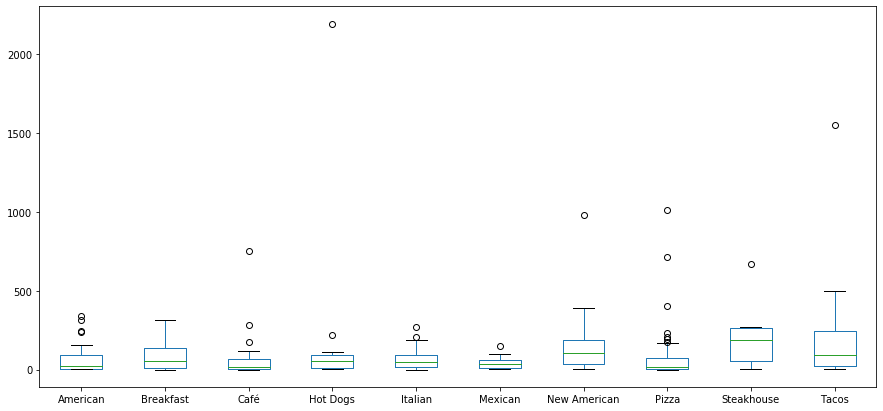

In [10]:
ten_likes_df = df_food_bus[df_food_bus['Business Category'].isin(ten_most_liked.index)].loc[:,['Business Category','Likes']]
df3 = ten_likes_df.pivot(columns=ten_likes_df.columns[0], index=ten_likes_df.index)
df3.columns = df3.columns.droplevel()
df3.boxplot(figsize=(15,7), grid=False)

The box plot of the restaurant types with the largest total amount of likes is shown above. All of the boxes on this chart appear realatively collapsed. This is because there are a small number of outlier businesses that are skewing results for the dataset. 
_______________________________

Next we will reproduce the same data for likes, but impose of maximum of limit of 500 likes to remove the outlier datapoints.

In [11]:
ten_most_liked_outlier = pd.Series(df_food_bus[df_food_bus['Likes'] < 500].groupby('Business Category').Likes.sum()).nlargest(10)
ten_most_liked_outlier

Business Category
Pizza                 2587
Breakfast             2006
American              1963
Italian               1903
Mexican               1680
BBQ                   1442
Tacos                 1375
Sushi                 1305
New American          1283
Vegetarian / Vegan    1261
Name: Likes, dtype: int64

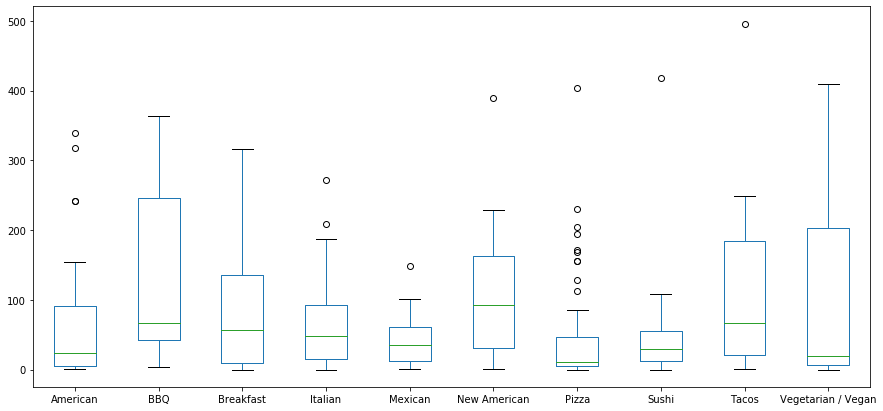

In [12]:
ten_likes_df_outlier = df_food_bus[df_food_bus['Business Category'].isin(ten_most_liked_outlier.index)].loc[:,['Business Category','Likes']]
ten_likes_df_outlier = ten_likes_df_outlier[ten_likes_df_outlier['Likes'] < 500]
df4 = ten_likes_df_outlier[ten_likes_df_outlier['Likes'] < 500].pivot(columns=ten_likes_df_outlier.columns[0], index=ten_likes_df_outlier.index)
df4.columns = df4.columns.droplevel()
df4.boxplot(figsize=(15,7), grid=False)

That looks much better! After removing the outlier data points the box chart shows a much clearer picture. According to this data, the following restuarant types have the higest mean amount of likes:
1. New American
2. BBQ
3. Tacos
4. Breakfast

Knowing this information, these specific types of restaurants would be a good recomendation to our stakeholders.

__________________

Now lets look at similar data, but group the likes by differnt Locations. This will help us in selecting an ideal Location to reccomend.


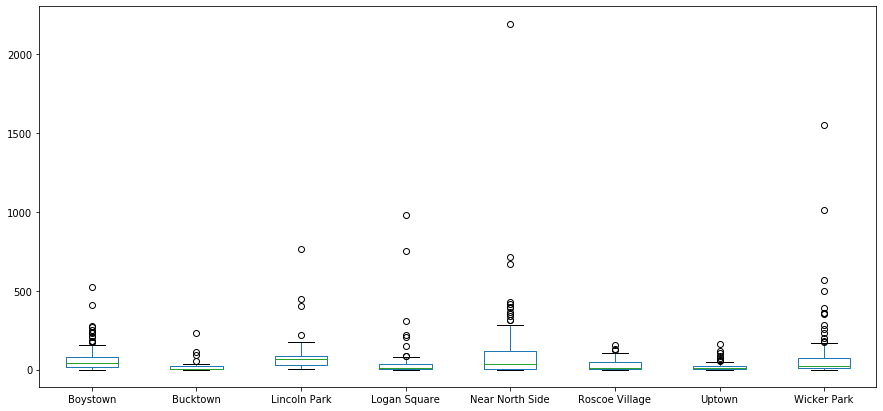

In [13]:
by_area = df_food_bus.loc[:,['Location','Likes']]
df5 = by_area.pivot(columns=by_area.columns[0], index=by_area.index)
df5.columns = df5.columns.droplevel()
df5.boxplot(figsize=(15,7), grid=False)

Again it looks like we have some outlier data points skewing are data. Let's set another maximum limit for likes at 500.

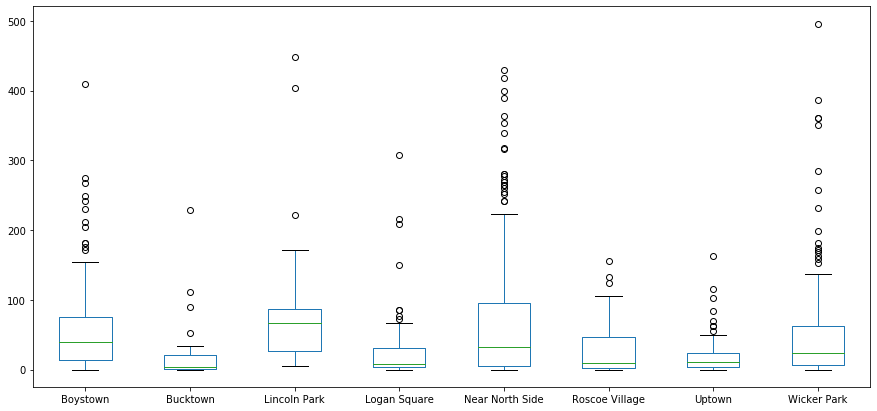

In [14]:
by_area_outlier = by_area[by_area['Likes'] < 500]
df6 = by_area_outlier.pivot(columns=by_area_outlier.columns[0], index=by_area_outlier.index)
df6.columns = df6.columns.droplevel()
df6.boxplot(figsize=(15,7), grid=False)

That looks much better. 

It appears as if the Near North Side, Boystown and Lincoln Park may be the best locations to open a new restaurant. Wicker Park would also not be far behind.

# Discussion 

Based on the results presented above, specific areas appear to be better suited for opening a food or restaurant business. The top 4 areas are:

1. Near North Side 
2. Boystown 
3. Lincoln Park 
4. Wicker Park 

Of these top options, Lincoln Park has be far the smallest number of current food or restaurant businesses at 45. 
According to the "Likes" information, the most liked food types are the following:

1. New American 
2. BBQ 
3. Tacos 
4. Breakfast 

These types of food locations are likely to be the most successful in the locations discussed. 

# Conclusion

Chicago currently has a strong market for food and restuarant businesses. This report reviewed 8 seperate locations and 686 indvidual existing businesses. 

Based on the currently available data from the Foursqaure API, it is recomended that a BBQ, Taco or Breakfast food business be opened in the Lincoln Park area, in order to maximize the possiblity of success. 

